# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


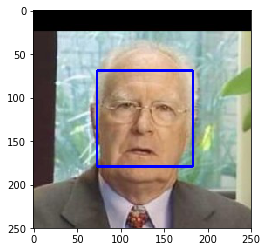

In [11]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[1000])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [46]:
faces

array([[ 73,  69, 110, 110]], dtype=int32)

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [34]:
# returns "True" if face is detected in image stored at img_path
import os

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [32]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
    

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

#checking accuracy in human_files_short
human_correct = 0
for image in human_files_short:
    if face_detector(image) == True:
        human_correct += 1
        
face_human_accuracy = (human_correct / len(human_files_short)) * 100
print(face_human_accuracy)


#checking accuracy in dog_files_short
dog_correct = 0
for image in dog_files_short:
    if face_detector(image) == False:
        dog_correct += 1

face_dog_accuracy = (dog_correct / len(dog_files_short)) * 100
print(100 - face_dog_accuracy)

98.0
17.0


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [12]:
import torch
import torchvision.models as models

# define VGG16 model

VGG16 = models.vgg16(pretrained=True)
VGG16.to(device)

"""
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
"""

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 89703943.81it/s]


'\n# check if CUDA is available\nuse_cuda = torch.cuda.is_available()\n\n# move model to GPU if CUDA is available\nif use_cuda:\n    VGG16 = VGG16.cuda()\n'

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [13]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path 
    img_pil = Image.open(img_path)
    
    preprocess = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
    
    img_tensor = preprocess(img_pil)
    img_tensor.unsqueeze_(0)
    
    ## Return the *index* of the predicted class for that image
    
    img_tensor = img_tensor.to(device)
    VGG16.to(device)
    
    output = VGG16(img_tensor)
    output = output.cpu()
    prediction = output.data.numpy().argmax()
    
    return prediction # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [14]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    prediction = VGG16_predict(img_path)
    
    dog_or_not = True
    if prediction < 151 or prediction > 268:
        dog_or_not = False
    
    
    return dog_or_not # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [36]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dog_in_human = 0
for image in human_files_short:
    if dog_detector(image) == True:
        dog_in_human += 1
        
dog_in_human_pct = (dog_in_human / len(human_files_short)) * 100
print(dog_in_human_pct)


#checking accuracy in dog_files_short
dog_in_dog = 0
for image in dog_files_short:
    if dog_detector(image) == True:
        dog_in_dog += 1

dog_in_dog_pct = (dog_in_dog / len(dog_files_short)) * 100
print(dog_in_dog_pct)

1.0
100.0


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [15]:
#Checking size and color channels of images in question
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

im = Image.open(human_files[0])
print(im.size)
print(im.mode)

(250, 250)
RGB


In [38]:
train_dir = "/data/dog_images/train"
valid_dir = "/data/dog_images/valid"
test_dir = "/data/dog_images/test"

In [39]:
import os
from torchvision import datasets, transforms
import torch.utils.data

#defining transformations
#write note about where normalization numbers are coming from
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

#configuring datasets
train_data = datasets.ImageFolder(train_dir, transform = train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform = valid_transform)
test_data = datasets.ImageFolder(test_dir, transform = test_transform)

#configuring dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 34, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = 34, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 34, shuffle = True)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: The code resizes the images one way for training and another (identical) way for validation and testing. For training, the delta wrt validation and testing is random horizontal flip; this helps the network generalize better. In general, big images are not efficient to process and hence, ultimately resizing the image down to 224 is a good practice. Normalization of data is key for networks to be able to process it; I have employed mean and std from ImageNet, as the images fed to the nn in this case are similar to the ones employed in ImageNet. The best practice, however, would have been to calculate the mean and std for the dataset employed in this instance. 

I decided to augment the dataset by doing horizontal random flips (read above) and random resized crops. In essence, this helps the nn become invariant to position of target object in the image. 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [40]:
from torch import nn, cuda
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
      

        self.conv1 = nn.Conv2d(3, 16, 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride = 1, padding = 1)
        
        self.conv_ban2 = nn.BatchNorm2d(16)
        self.conv_ban3 = nn.BatchNorm2d(32)
        self.conv_ban4 = nn.BatchNorm2d(64)
        
        
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        self.fc2 = nn.Linear(500, 133)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        
        x = self.conv_ban2(self.pool(F.relu(self.conv1(x))))
        x = self.conv_ban3(self.pool(F.relu(self.conv2(x))))
        x = self.conv_ban4(self.pool(F.relu(self.conv3(x))))

        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
        
        
#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

use_cuda = cuda.is_available()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ To start of with, added a few conv layers, but not too many as this has proven to lead to worse results (except when residual components are employed). Then added an fc layer for classification. Employed relu and pooling, as is standard in CNNs.

In the forward pass, employed batch norm to ensure that the different conv layers perceive the same plane of reality, regarding the data. Also employed dropout in the fc1 layer to promote a healthier learning / distribution of relevance accross the neurons

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [41]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr = 0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [16]:
import numpy as np

def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            
    # return trained model
    return model

In [15]:
# train the model
model_scratch = train(100, train_loader, valid_loader, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 907.897064 	Validation Loss: 110.349338
Epoch: 2 	Training Loss: 873.519786 	Validation Loss: 107.744616
Epoch: 3 	Training Loss: 845.561884 	Validation Loss: 103.035249
Epoch: 4 	Training Loss: 835.112684 	Validation Loss: 99.673677
Epoch: 5 	Training Loss: 810.983325 	Validation Loss: 97.269606
Epoch: 6 	Training Loss: 795.538646 	Validation Loss: 95.080015
Epoch: 7 	Training Loss: 782.641051 	Validation Loss: 95.066497
Epoch: 8 	Training Loss: 770.211605 	Validation Loss: 93.034026
Epoch: 9 	Training Loss: 758.880592 	Validation Loss: 92.843439
Epoch: 10 	Training Loss: 741.914603 	Validation Loss: 89.718934
Epoch: 11 	Training Loss: 735.759861 	Validation Loss: 92.284352
Epoch: 12 	Training Loss: 715.642311 	Validation Loss: 86.746835
Epoch: 13 	Training Loss: 707.000207 	Validation Loss: 88.122897
Epoch: 14 	Training Loss: 697.334768 	Validation Loss: 87.211082
Epoch: 15 	Training Loss: 687.513896 	Validation Loss: 87.023351
Epoch: 16 	Training Loss: 682.5

KeyboardInterrupt: 

In [43]:
import torch
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [17]:
import numpy as np
from torch import cuda

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [45]:
# call test function    
test(test_loader , model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.035891


Test Accuracy: 25% (216/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [18]:
import os
from torchvision import datasets, transforms
import torch.utils.data

## TODO: Specify data loaders

train_dir = "/data/dog_images/train"
valid_dir = "/data/dog_images/valid"
test_dir = "/data/dog_images/test"


#defining transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

#configuring datasets
train_data = datasets.ImageFolder(train_dir, transform = train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform = valid_transform)
test_data = datasets.ImageFolder(test_dir, transform = test_transform)

#configuring dataloaders
train_loader_transf = torch.utils.data.DataLoader(train_data, batch_size = 34, shuffle = True)
valid_loader_transf = torch.utils.data.DataLoader(valid_data, batch_size = 34, shuffle = True)
test_loader_transf = torch.utils.data.DataLoader(test_data, batch_size = 34, shuffle = True)



### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [19]:
import torchvision.models as models
import torch.nn as nn
import torch.cuda as cuda

## TODO: Specify model architecture 

model_transfer = models.densenet121(pretrained = True)
in_features = model_transfer.classifier.in_features

for param in model_transfer.features.parameters():
    param.require_grad = False

classifier = nn.Sequential(
                            nn.Dropout(p = 0.2),
                            nn.Linear(in_features, 133),
                            nn.LogSoftmax(dim=1)
                          )
model_transfer.classifier = classifier

if cuda.is_available():
    model_transfer = model_transfer.cuda()

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 81090333.64it/s]


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ Simply downloaded a pretrained version of densenet121. Froze params in features section, to be able to leverage it´s inherent object detection ability. Added a new classifier to repurpose the network for the current classification task (133 classes). Employed dropout, again, to allow for a healthier learning and allow the network to generalize better. 


In [20]:
from torch import nn, optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr = 0.001)

In [21]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# train the model
use_cuda = torch.cuda.is_available()
model_transfer =  train(40, train_loader_transf, valid_loader_transf, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')



Epoch: 1 	Training Loss: 464.042026 	Validation Loss: 43.982274
Epoch: 2 	Training Loss: 374.578703 	Validation Loss: 38.073967
Epoch: 3 	Training Loss: 333.928016 	Validation Loss: 33.517575
Epoch: 4 	Training Loss: 299.306521 	Validation Loss: 25.871829
Epoch: 5 	Training Loss: 276.618348 	Validation Loss: 25.851368
Epoch: 6 	Training Loss: 262.098224 	Validation Loss: 24.938784
Epoch: 7 	Training Loss: 250.338928 	Validation Loss: 21.339887
Epoch: 8 	Training Loss: 243.823012 	Validation Loss: 21.501195
Epoch: 9 	Training Loss: 225.230599 	Validation Loss: 20.012545


In [22]:
import torch
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [15]:
use_cuda = torch.cuda.is_available()
test(test_loader_transf, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.832367


Test Accuracy: 74% (626/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [23]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    
    #processing the image, to feed it into nn
    img_pil = Image.open(img_path)
    
    preprocess = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
    
    img_tensor = preprocess(img_pil)
    img_tensor.unsqueeze_(0)
    
    #move network to device + perform forward pass + translate output into idx (prediction)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model_transfer.to(device)
    img_tensor = img_tensor.to(device)
    output = model_transfer(img_tensor)
    output = output.cpu()
    prediction = output.data.numpy().argmax()
    
    breed = class_names[prediction]
    return breed

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [24]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    if face_detector(img_path) == True:
        resembling_breed = predict_breed_transfer(img_path)
        print("Hi, human! You look like a {}".format(resembling_breed))
        pass
    if dog_detector(img_path) == True:
        predicted_breed = predict_breed_transfer(img_path)
        print("Wow, nice dog! It looks to me like a {}".format(predicted_breed))
        pass
    if face_detector(img_path) == False and dog_detector(img_path) == False:
        print("Woops. Looks like there´s not a human or a dog in the picture you uploaded")
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ It´s not working exceptionally. 

Points of improvement:

Human detection seems to work fine, so the issue is more with recognizing dog breeds. Hence, one may improve the algo the following 3 ways:

1. Employing a larger data set of dogs
2. Training the network during more epochs (in the case of the transfer learning instance)
3. Fine tuning the CNN network further, adding residual components to it (or using Resnet50 instead of Densenet121)
 

In [25]:
import numpy as np
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

In [36]:
run_app('real_images/daschund1.jpg')

Wow, nice dog! It looks to me like a Chinese crested


In [42]:
run_app('real_images/mark.jpg')

Hi, human! You look like a Cane corso


In [38]:
run_app('real_images/cocker_spaniel.jpg')

Wow, nice dog! It looks to me like a Basset hound


In [44]:
run_app('real_images/german_sheperd2.jpg')

Wow, nice dog! It looks to me like a Cane corso


In [40]:
run_app('real_images/andrew.jpg')

Hi, human! You look like a American staffordshire terrier
